In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
from neo4j import GraphDatabase
import matplotlib.pyplot as plt

In [2]:
# Seen from :server status
uri = "bolt://localhost:7687"

# default user for graph database is neo4j
# auth = ("neo4j", "password")
auth = ("neo4j","quickstart")

driver = GraphDatabase.driver(uri = uri, auth = auth)
driver.verify_connectivity()

C:\Users\irsya\AppData\Local\Temp/ipykernel_4448/1292716654.py:9: ExperimentalWarning: The configuration may change in the future.
  driver.verify_connectivity()


'Neo4j/4.4.4'

#### Calculating PageRank on Zach's Karate Club (<code> "../neo4j_quickstart/adv_importing.ipynb" </code>)

To run a graph algorithm, we first need to specify a portion of the graph we are going to use. In this case, let us ue the whole graph.

@cypher:

    CALL gds.graph.project.(
    'ilovekarate',
    ["Person"],
    {
        WEIGHT: {orientation: "NATURAL"}
    }
    )

Documentation: 

    CALL gds.graph.project.cypher(
        graphName: String,
        nodesIncluded: [str]
        relationshipsIncluded: {
                                relationship: {orientation: "Natural" or "UNDIRECTED"}
                                relationship: {orientation: "Natural" or "UNDIRECTED"}
                                relationship: {orientation: "Natural" or "UNDIRECTED"}
                               }
                                

In [45]:
class pagerank:
    def __init__(self, driver) -> None:
        """
        Args:
            driver is GraphDatabase.driver
        """
        self.driver = driver

    def close(self) -> None:
        self.driver.close()

    #estimation for memory
    @classmethod
    def write(cls, tx) -> any:
        """
        @param cls is the class
        @param tx is the transaction
        @returns the data for the memory
        """
        query = ("""
                    CALL gds.pageRank.write('ilovekarate', {
                    maxIterations: 20,
                    dampingFactor: 0.85,
                    writeProperty: 'pagerank'
                    })
                    YIELD nodePropertiesWritten, ranIterations
                """)
        result = tx.run(query)
        #returns dataframe
        return result.data()

    @classmethod
    def pagerank(cls, tx) -> any:
        """
        @param cls is the class
        @param tx is the transaction
        @return result.data() is the data of the pagerank
        """
        query = ("""
                    Call gds.pageRank.stream('ilovekarate') 
                    YIELD nodeId, score RETURN gds.util.asNode(nodeId).id AS id, gds.util.asNode(nodeId).club AS club, score AS pagerank
                    ORDER BY score DESC, id ASC
                """)
        result = tx.run(query)
        #return a dataframe
        return result.data() 


    def write_pagerank(self) -> any:
        """
        @param self
        @return result is the result of the memory estimation
        """
        result = self.driver.session().write_transaction(self.write)
        return pd.DataFrame(result)


    def run_pagerank(self) -> any:
        """
        @param self
        @return result is the dataframe from the pagerank
        """
        result = self.driver.session().write_transaction(self.pagerank)
        return pd.DataFrame(result)

In [46]:
hello = pagerank(driver)

In [47]:
data = hello.run_pagerank()
data.head()

,id,club,pagerank
0,33,Officer,3.287865
1,0,Mr. Hi,3.162529
2,32,Officer,2.336371
3,2,Mr. Hi,1.856204
4,1,Mr. Hi,1.721732


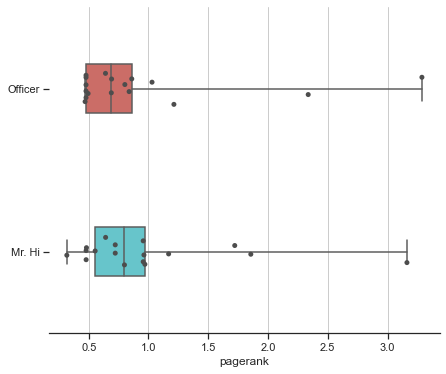

In [48]:
sns.set(font_scale = 1.5)
sns.set_theme()

def barplot(x, y, data):
    """
    :param x: is the x axis
    :param y: is the y axis
    :param data: is the data used
    """
    sns.set_theme(style="ticks")

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=(7, 6))
    ax.set_xscale("linear")

    # Plot the orbital period with horizontal boxes
    sns.boxplot(x=x, y=y, data=data,
        whis=[0, 100], width=0.3, palette="hls")

    # Add in points to show each observation
    sns.stripplot(x=x, y=y, data=data,
                size=5, color=".3", linewidth=0)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=False, left=True)

    plt.show()

barplot("pagerank", "club", data)

This can also be seen in Neo4j Bloom as well!

In [49]:
hello.write_pagerank()

,nodePropertiesWritten,ranIterations
0,34,20


(See in Neo4j Bloom)